In [2]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
from scipy.stats import skew,kurtosis

In [3]:
# Reading all the files
raw_path = 'C:/Users/Siddi/Downloads/dataset/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
olist_product_translation = pd.read_csv(raw_path + 'product_category_name_translation.csv')

### Pre-Processing the Data

In [4]:
#Analyzing the initial rows and columns of customer dataset
print(olist_customer.head())

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


In [5]:
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments, 
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments', 
            'olist_order_reviews', 'olist_products', 'olist_sellers']

In [6]:
# Creating a DataFrame with useful information about all datasets
df_info = pd.DataFrame({})
df_info['dataset'] = names
df_info['n_rows'] = [df.shape[0] for df in datasets]
df_info['n_cols'] = [df.shape[1] for df in datasets]
df_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
df_info['null_columns_qty'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
df_info['null_columns_names'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

df_info.style.background_gradient()

In [7]:
#Handling Missing Values
olist_orders = olist_orders.drop(columns=['order_approved_at' , 'order_delivered_customer_date', 'order_delivered_carrier_date'])
olist_products = olist_products.drop(columns=["product_weight_g","product_name_lenght", "product_description_lenght", "product_photos_qty", "product_height_cm", "product_width_cm", "product_length_cm"])
olist_order_reviews = olist_order_reviews.drop(columns=['review_comment_title', 'review_comment_message'])

## Analysing Variables and performing Exploratory Data Analysis

### Performing EDA with an intent to answer the below questions and seek more insights into the Brazilian Ecommerce Market 

#### 
1. How many Orders do we have for each status?
2. What is the purchasing trend from E-commerce website in Brazil?
3. What time and day of the week brazilians customers tend to do online purchasing?
We can categorize them as Dawn, Morning, Afternoon or Night

In [8]:
olist_orders.head(10)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
5  a4591c265e18cb1dcee52889e2d8acc3  503740e9ca751ccdda7ba28e9ab8f608   
6  136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   
7  6514b8ad8028c9f2cc2374ded245783f  9bdf08b4b3b52b5526ff42d37d47f222   
8  76c6e866289321a7c93b82b54852dc33  f54a9f0e6b351c431402b8461ea51999   
9  e69bfb5eb88e0ed6a785585b27e16dbf  31ad1d1b63eb9962463f764d4e6e0c9d   

  order_status order_purchase_timestamp order_estimated_delivery_date  
0    delivered      2017-10-02 10:56:33           2017-10-18 00:00:00  
1    delivered      2018-07-24 20:41:37           2018-08-13 00:00:00  
2    delivered      2018-08-08 08:38:49           2018-09-04 00:00:00  
3    delivered      2017-11-18 19:28:06           2017-12-15 00:00:00  
4    delivered      2018-02-13 21:18:39           2018-02-26 00:00:00  
5    delivered      2017-07-09 21:57:05           2017-08-01 00:00:00  
6     invoiced      2017-04-11 12:22:08           2017-05-09 00:00:00  
7    delivered      2017-05-16 13:10:30           2017-06-07 00:00:00  
8    delivered      2017-01-23 18:29:09           2017-03-06 00:00:00  
9    delivered      2017-07-29 11:55:02           2017-08-23 00:00:00

In [9]:
olist_orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [10]:
df = olist_orders.groupby(["order_status"]).size().reset_index(name='status_qt')

fig = px.bar(df,
             y='status_qt',
             x="order_status", color='order_status',
             labels={'status_qt':'Total Count of Status'}, height=600)
fig.show()

It can be noted that the highest count of order status are 'Delivered' type

#### Evaluation of Purchase Orders

In [11]:
# Changing the data type for date columns
olist_orders['order_purchase_timestamp']=pd.to_datetime(olist_orders['order_purchase_timestamp'])
olist_orders['order_estimated_delivery_date']=pd.to_datetime(olist_orders['order_estimated_delivery_date'])

In [12]:
# Extracting attributes for purchase date - Year and Month
olist_orders['order_purchase_year'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.year)
olist_orders['order_purchase_month'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.month)
olist_orders['order_purchase_month_name'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
olist_orders['order_purchase_year_month'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
olist_orders['order_purchase_date'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

In [13]:
# Extracting attributes for purchase date - Day and Day of Week
olist_orders['order_purchase_day'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.day)
olist_orders['order_purchase_dayofweek'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
olist_orders['order_purchase_dayofweek_name'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

In [14]:
# Extracting attributes for purchase date - Hour and Time of the Day
olist_orders['order_purchase_hour'] = olist_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
olist_orders['order_purchase_time_day'] = pd.cut(olist_orders['order_purchase_hour'], hours_bins, labels = hours_labels)

In [15]:
# New DataFrame after transformations
olist_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp order_estimated_delivery_date  \
0    delivered      2017-10-02 10:56:33                    2017-10-18   
1    delivered      2018-07-24 20:41:37                    2018-08-13   
2    delivered      2018-08-08 08:38:49                    2018-09-04   
3    delivered      2017-11-18 19:28:06                    2017-12-15   
4    delivered      2018-02-13 21:18:39                    2018-02-26   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night

In [16]:
#defining visualization functions
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def single_countplot(df, ax, x=None, y=None, order=True, hue=False, palette='plasma', width=0.75, sub_width=0.3,
                     sub_size=12):



    ncount = len(df)
    if x:
        col = x
    else:
        col = y
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

C:\Users\Siddi\AppData\Local\Temp\ipykernel_16928\1099663289.py:43: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



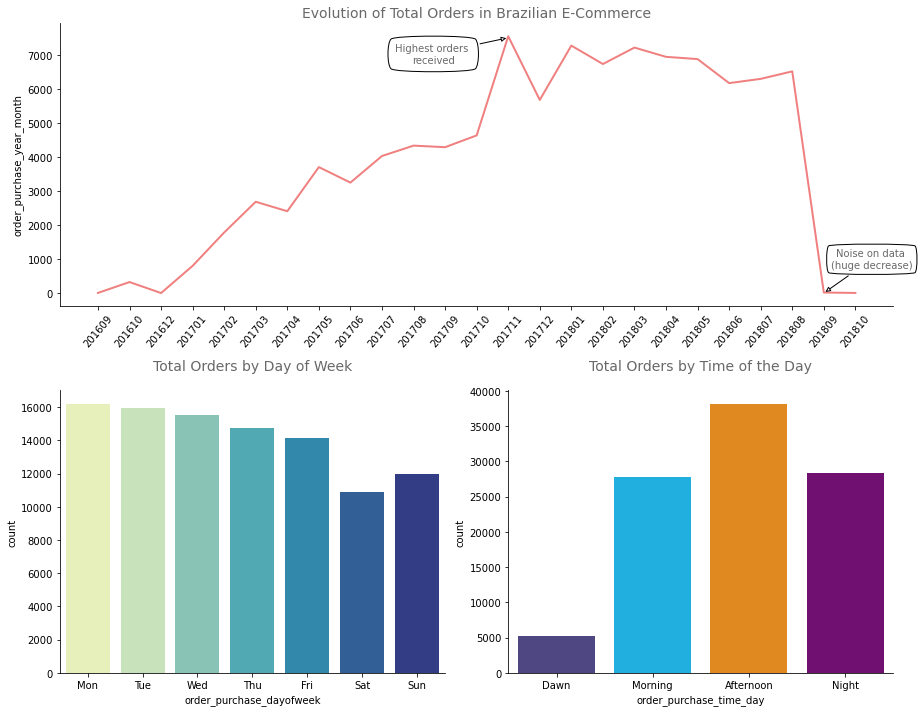

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=olist_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='lightcoral', linewidth=2)

ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

#format_spines(ax1, right_border=False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for tick in ax1.get_xticklabels():
    tick.set_rotation(50)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')


# Barchart - Total of orders by day of week
single_countplot(olist_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(olist_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

We observe distinct seasonal patterns, with a notable peak in November, mainly attributed to Black Friday. Sales tend to dip after December, following the year-end holiday season. However, it's evident that overall, customers are making more purchases compared to previous periods.

Mondays appear to be the preferred day for customers to shop, and they tend to make more purchases during the afternoon.

There is a noticeable sharp decrease in sales between August 2018 and September 2018. This dip may be attributed to data anomalies or irregularities.

##### Analyzing which product categories are ordered the most by customers. This would help to send out specifc promotions or product ads to increase engagement and thereby increasing profitability 

In [18]:
#Taking help of olist_product_translation dataset to convert the portugese product names into English
updated_product_df = pd.merge(olist_products, olist_product_translation, on='product_category_name')
updated_product_df.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)
updated_product_df.drop('product_category_name', axis=1, inplace=True)

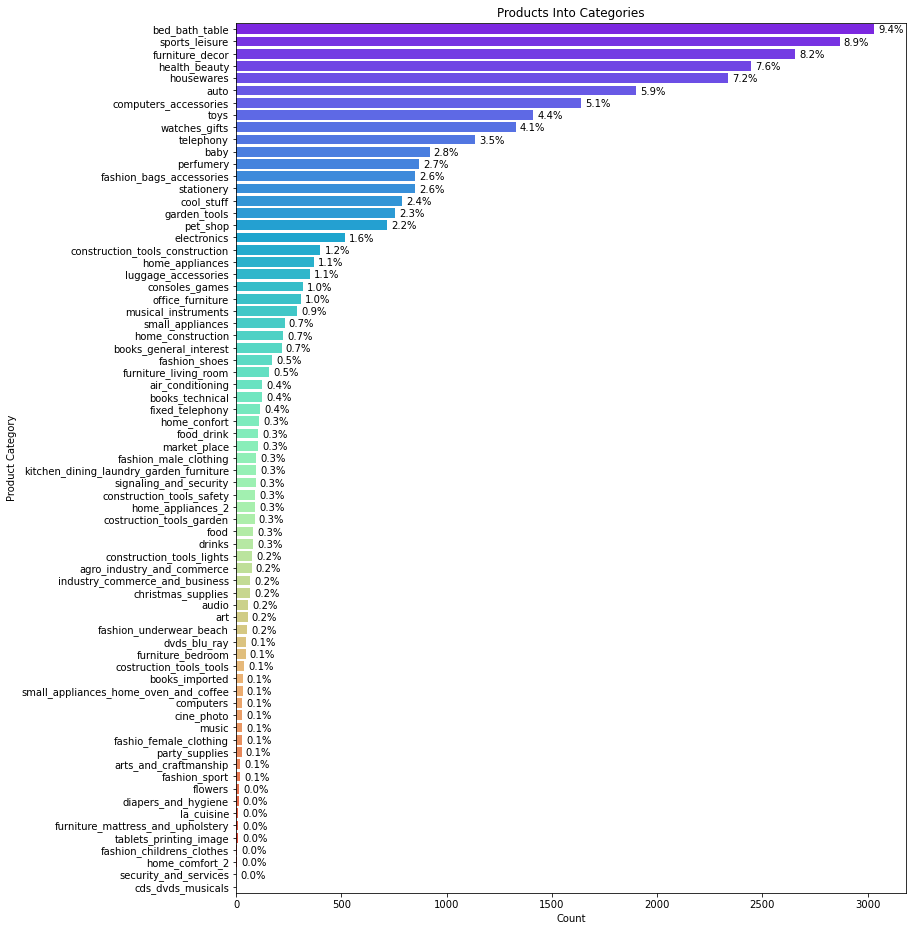

In [19]:
fig = plt.figure(figsize=(12, 16))
ax = sns.countplot(y=updated_product_df['product_category'], palette='rainbow',
                   order = updated_product_df['product_category'].value_counts().index)
total = len(updated_product_df['product_category'])
for p in ax.patches:
    x = (p.get_width() + 80)
    y = (p.get_y() + p.get_height()/2) + 0.9
    ax.annotate('{:.1f}%'.format(100 * p.get_width()/total), (x,y),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Products Into Categories')
plt.ylabel('Product Category')
plt.xlabel('Count')

plt.savefig('Products')

Additionally, I've conducted a comprehensive Payment Type Analysis to gain valuable insights into the primary payment methods preferred by our customers. This analysis not only sheds light on the major modes of payment but also delves into whether customers are opting for installment-based purchases. If so, we've gone a step further to ascertain the average duration of these installment plans. These findings are pivotal in our efforts to better understand the demographics and behaviors of our customer base.

This analysis has the potential to unearth several key insights, such as:

1. **Dominant Payment Modes:** Identifying the predominant payment methods gives us an understanding of how customers prefer to complete their transactions. This knowledge is beneficial for tailoring our payment processing options to align with customer preferences, potentially increasing conversion rates.

2. **Installment Purchases:** Discovering whether customers are frequently utilizing installment-based payment plans offers insights into their financial flexibility and purchasing habits. This information can be vital for creating tailored marketing and product offerings, especially if a significant portion of our customers opts for installment payments.

3. **Average Installment Duration:** Calculating the average duration of installment plans provides us with a deeper understanding of the financial commitment our customers are willing to make. This information can guide product development, pricing strategies, and marketing efforts.

4. **Customer Demographics:** By analyzing payment choices and installment tendencies, we can draw conclusions about the demographics of our customer base. Are certain payment methods more popular among specific age groups or geographic regions? Are installment plans favored by particular customer segments? This knowledge can help in crafting targeted marketing campaigns and tailoring product offerings to specific customer groups.

Overall, the Payment Type Analysis is a valuable tool for enhancing our understanding of our customers' preferences, habits, and financial behaviors. By leveraging these insights, we can make informed decisions that drive business growth and customer satisfaction.

In [20]:
olist_order_payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

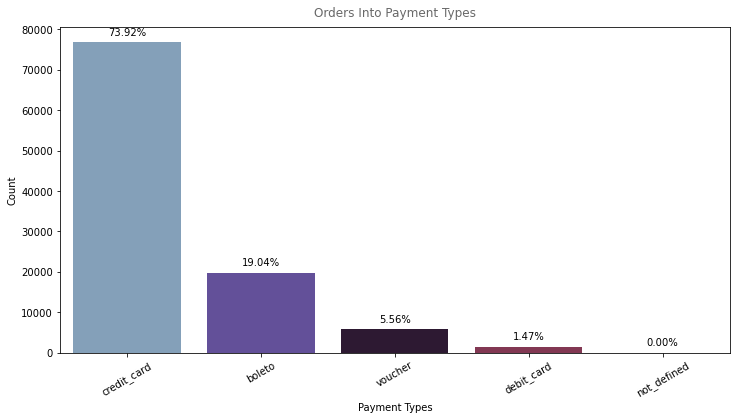

In [21]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x=olist_order_payments['payment_type'], palette='twilight')
total = len(olist_order_payments['payment_type'])
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * p.get_height()/total), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Orders Into Payment Types', size=12, color='dimgrey', pad=10)
plt.ylabel('Count')
plt.xlabel('Payment Types')

plt.savefig('Products')


Boleto Bancário, commonly referred to as Boleto, is a popular payment method in Brazil. It is a type of payment voucher that allows customers to make purchases or pay bills, both online and offline. Boleto is unique in that it doesn't require the payer to have a bank account or a credit card. 

When a customer chooses to pay with Boleto, a printable voucher is generated, often with a barcode. The customer can either print the voucher or save it digitally and then take it to a participating bank, post office, or authorized retail location for payment. Alternatively, some online platforms allow customers to pay Boleto vouchers directly online.

In some ways, Boleto is similar to credit cards in that it provides a convenient method for making payments. However, it differs in that it is a prepaid system, meaning the payer must deposit the necessary funds into the voucher before it can be used for a purchase. This contrasts with credit cards, which offer a line of credit to the cardholder. Despite these distinctions, Boleto remains a widely accepted and accessible payment method in Brazil, catering to those without credit cards or bank accounts.

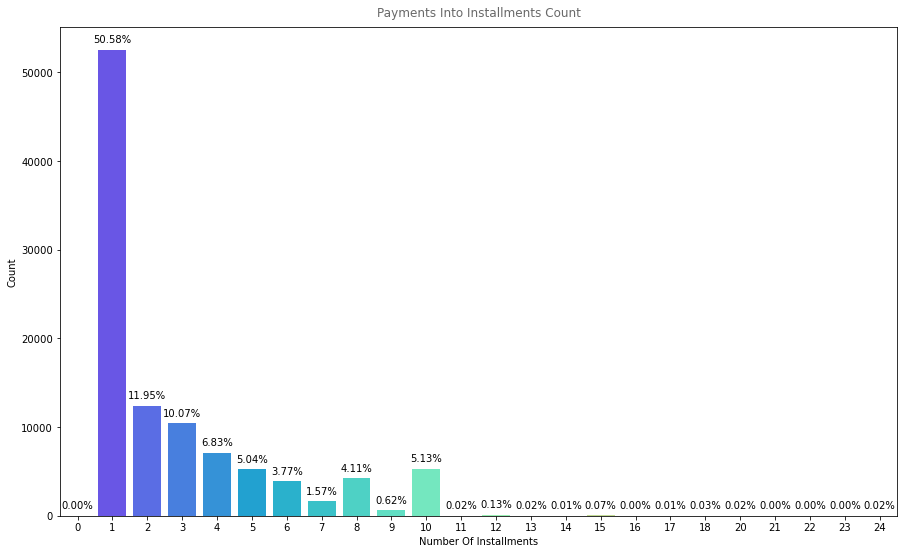

In [22]:
fig = plt.figure(figsize=(15, 9))
ax = sns.countplot(x=olist_order_payments['payment_installments'], palette='rainbow')
total = len(olist_order_payments['payment_installments'])
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * p.get_height()/total), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Payments Into Installments Count', size=12, color='dimgrey', pad=10)
plt.ylabel('Count')
plt.xlabel('Number Of Installments')

plt.savefig('Products')

In [23]:
print("Average value of transaction on credit card : BRL {:,.0f}".format(np.mean(olist_order_payments[olist_order_payments.payment_type=='credit_card']['payment_value'])))
print("Average value of transaction on boleto : BRL {:,.0f}".format(np.mean(olist_order_payments[olist_order_payments.payment_type=='boleto']['payment_value'])))
print("Average value of transaction on voucher: BRL {:,.0f}".format(np.mean(olist_order_payments[olist_order_payments.payment_type=='voucher']['payment_value'])))
print("Average value of transaction on debit card: BRL {:,.0f}".format(np.mean(olist_order_payments[olist_order_payments.payment_type=='debit_card']['payment_value'])))

Average value of transaction on credit card : BRL 163
Average value of transaction on boleto : BRL 145
Average value of transaction on voucher: BRL 66
Average value of transaction on debit card: BRL 143


###### Let's understand how customers have chosen the payment type for different transaction values 

In [24]:
print("Credit Card quantiles")
print(olist_order_payments[olist_order_payments.payment_type=='credit_card']['payment_value'].quantile([.01,.25,.5,.75,.99]))
print("")
print("Boleto quantiles")
print(olist_order_payments[olist_order_payments.payment_type=='boleto']['payment_value'].quantile([.01,.25,.5,.75,.99]))
print("")
print("Voucher quantiles")
print(olist_order_payments[olist_order_payments.payment_type=='voucher']['payment_value'].quantile([.01,.25,.5,.75,.99]))
print("")
print("Debit Card quantiles")
print(olist_order_payments[olist_order_payments.payment_type=='debit_card']['payment_value'].quantile([.01,.25,.5,.75,.99]))

Credit Card quantiles
0.01      13.4100
0.25      62.2100
0.50     106.8700
0.75     181.2100
0.99    1097.3334
Name: payment_value, dtype: float64

Boleto quantiles
0.01     21.7500
0.25     55.5225
0.50     93.8900
0.75    160.7625
0.99    946.9896
Name: payment_value, dtype: float64

Voucher quantiles
0.01      0.7170
0.25     18.0350
0.50     39.2800
0.75     80.0000
0.99    454.5824
Name: payment_value, dtype: float64

Debit Card quantiles
0.01     20.7412
0.25     51.1000
0.50     89.3000
0.75    154.3200
0.99    941.1528
Name: payment_value, dtype: float64


[Text(0, 0, 'credit_card'),
 Text(1, 0, 'boleto'),
 Text(2, 0, 'voucher'),
 Text(3, 0, 'debit_card'),
 Text(4, 0, 'not_defined')]

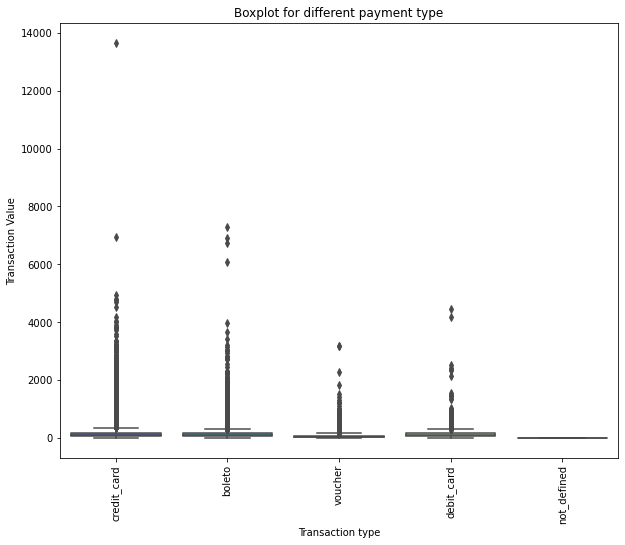

In [25]:
plt.figure(figsize=(10,8))
ax=sns.boxplot(x=olist_order_payments.payment_type,y=olist_order_payments.payment_value,palette=sns.color_palette(palette="rainbow"))
ax.set_title("Boxplot for different payment type")
ax.set_xlabel("Transaction type")
ax.set_ylabel("Transaction Value")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

Notably, extreme outliers are visible in the dataset, primarily at higher transaction values, indicating a preference for credit-based payments for larger purchases. Debit cards and vouchers are less commonly used in such cases. Moreover, the distribution plot reveals two distinct modes, reflecting dominant payment patterns and guiding potential optimizations for payment processing options.

## Feature Engineering

### Performing RFM Modeling which is Recency, Frequency and Monetary Value

#### Recency measures how recently a customer made a purchase. It can help to identify active and inactive customers.

In [26]:
#Code to calculate recency
reference_date = '2018-04-11' #reference date was chosen based on top date when maximum orders were made throughout the daterange
olist_orders['order_purchase_timestamp'] = pd.to_datetime(olist_orders['order_purchase_timestamp'])
last_purchase_date = olist_orders.groupby('customer_id')['order_purchase_timestamp'].max()
last_purchase_date = last_purchase_date.reset_index()
last_purchase_date['purchase_recency'] = (pd.to_datetime(reference_date) - last_purchase_date['order_purchase_timestamp']).dt.days
print(last_purchase_date[['customer_id', 'purchase_recency']])

                            customer_id  purchase_recency
0      00012a2ce6f8dcda20d059ce98491703               147
1      000161a058600d5901f007fab4c27140               268
2      0001fd6190edaaf884bcaf3d49edf079               406
3      0002414f95344307404f0ace7a26f1d5               237
4      000379cdec625522490c315e70c7a9fb                 8
...                                 ...               ...
99436  fffecc9f79fd8c764f843e9951b11341                12
99437  fffeda5b6d849fbd39689bb92087f431               -42
99438  ffff42319e9b2d713724ae527742af25               -64
99439  ffffa3172527f765de70084a7e53aae8               220
99440  ffffe8b65bbe3087b653a978c870db99               193

[99441 rows x 2 columns]


In [27]:
# Merge the 'recency' values into the 'orders_df' DataFrame
olist_orders = pd.merge(olist_orders, last_purchase_date[['customer_id', 'purchase_recency']], on='customer_id', how='left')

# Print the updated 'orders_df' with the 'recency' column
print(olist_orders[['customer_id', 'order_purchase_timestamp', 'purchase_recency']])

                            customer_id order_purchase_timestamp  \
0      9ef432eb6251297304e76186b10a928d      2017-10-02 10:56:33   
1      b0830fb4747a6c6d20dea0b8c802d7ef      2018-07-24 20:41:37   
2      41ce2a54c0b03bf3443c3d931a367089      2018-08-08 08:38:49   
3      f88197465ea7920adcdbec7375364d82      2017-11-18 19:28:06   
4      8ab97904e6daea8866dbdbc4fb7aad2c      2018-02-13 21:18:39   
...                                 ...                      ...   
99436  39bd1228ee8140590ac3aca26f2dfe00      2017-03-09 09:54:05   
99437  1fca14ff2861355f6e5f14306ff977a7      2018-02-06 12:58:58   
99438  1aa71eb042121263aafbe80c1b562c9c      2017-08-27 14:46:43   
99439  b331b74b18dc79bcdf6532d51e1637c1      2018-01-08 21:28:27   
99440  edb027a75a1449115f6b43211ae02a24      2018-03-08 20:57:30   

       purchase_recency  
0                   190  
1                  -105  
2                  -120  
3                   143  
4                    56  
...                 ...  
9

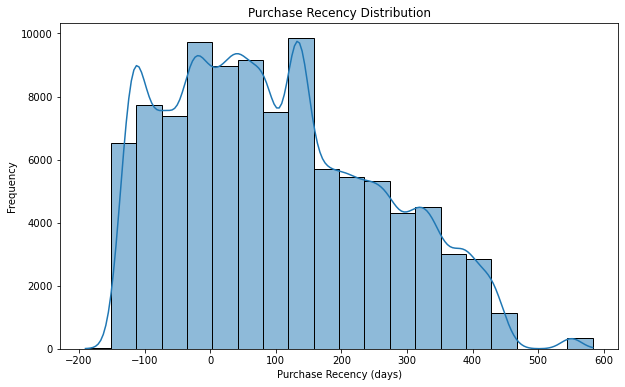

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot a histogram of purchase recency
plt.figure(figsize=(10, 6))
sns.histplot(data=olist_orders, x='purchase_recency', bins=20, kde=True)
plt.title('Purchase Recency Distribution')
plt.xlabel('Purchase Recency (days)')
plt.ylabel('Frequency')
plt.show()

#### Calculating Purchase Frequency

In [29]:
# Code to calculate frequency
purchase_frequency = olist_orders['customer_id'].value_counts().reset_index()
purchase_frequency.columns = ['customer_id', 'frequency']
print(purchase_frequency[['customer_id', 'frequency']])
olist_orders = pd.merge(olist_orders, purchase_frequency[['customer_id', 'frequency']], on='customer_id', how='left')

                            customer_id  frequency
0      9ef432eb6251297304e76186b10a928d          1
1      413f7e58270a32396af030a075b924be          1
2      eb4350b67a0264c67e5e06a038e4afbb          1
3      622b07d262d545d16efbd4363a89cb91          1
4      c701fbfa77791abd05eef9eacf7ea7a8          1
...                                 ...        ...
99436  39585f08d13377e50fde35467984e6eb          1
99437  eb3d995301c320683de629f5b4dd0c78          1
99438  f2507ea56d748a23037bb1214964e87d          1
99439  ae8269d850cd3a3d06a56877c450b3f8          1
99440  edb027a75a1449115f6b43211ae02a24          1

[99441 rows x 2 columns]


In [30]:
day_hour=olist_orders.groupby(['order_purchase_dayofweek_name','order_purchase_hour']).agg({'order_id':'count'}).rename(columns={'order_id':'freq'}).reset_index()

In [31]:
### Sorting it so that the plot order is correct.
day_hour['order_purchase_dayofweek_name']=pd.Categorical(day_hour['order_purchase_dayofweek_name'],categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],ordered=True)

In [32]:
day_hour.head()

order_purchase_dayofweek_name  order_purchase_hour  freq
0                           Fri                    0   426
1                           Fri                    1   216
2                           Fri                    2    72
3                           Fri                    3    49
4                           Fri                    4    40

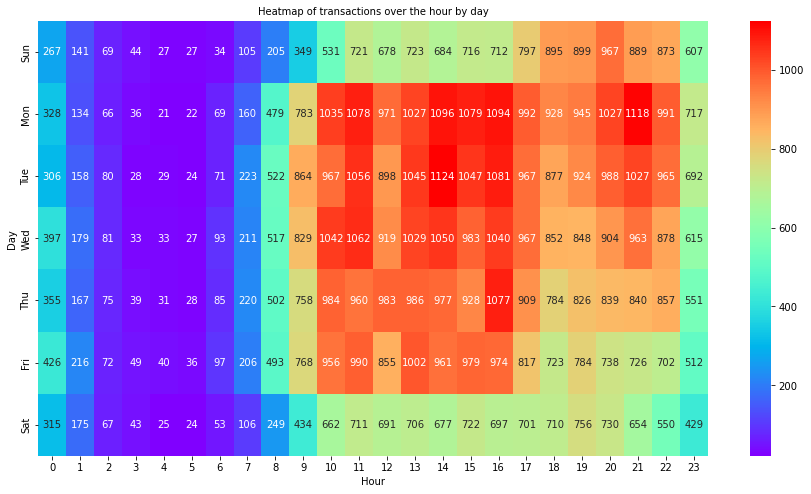

In [33]:
plt.figure(figsize=(15, 8))
ax = sns.heatmap(day_hour.pivot('order_purchase_dayofweek_name', 'order_purchase_hour', 'freq'), annot=True, fmt="d", cmap="rainbow")
ax.set_xlabel("Hour")
ax.set_ylabel("Day")
ax.set_title("Heatmap of transactions over the hour by day", size=10)

plt.show()


##### Analyzing the heatmap presented above, we can draw several key insights:

1. **Progressive Increase Throughout the Day:** The heatmap reveals a progressive increase in the number of orders as the day unfolds. This suggests that customers tend to place orders more frequently as the day goes on, peaking in the afternoon.

2. **Weekday-Weekend Discrepancy:** A noticeable distinction emerges between the order frequency on weekdays and weekends. On weekdays, we observe a steady rise in order frequency after 9 AM, indicating that customers start placing orders early in the day. In contrast, on Sundays, the order frequency doesn't significantly pick up until after 3:00 PM. This disparity suggests varying customer behavior and preferences on different days of the week.

##### Monetary value measures how much money a customer has spent. It identifies high-value and low-value customers.
1. Calculate the total order value for each order. Achieved by summing the prices of all products in each order.
2. Sum the order values for each customer.

In [34]:
# Merge the DataFrames to create a unified dataset
merged_df = pd.merge(olist_orders, olist_order_items, on='order_id', how='inner')
merged_df = pd.merge(merged_df, olist_products, on='product_id', how='inner')

# Calculate the total price for each item within an order
merged_df['total_price'] = merged_df['price'] * merged_df['order_item_id']

# Calculate the Order Value (OV) for each order
order_values = merged_df.groupby('order_id')['total_price'].sum().reset_index()

# Calculate the Monetary Value (M) for each customer by summing their Order Values
monetary_values = order_values.merge(olist_orders[['order_id', 'customer_id']], on='order_id', how='inner')
monetary_values = monetary_values.groupby('customer_id')['total_price'].sum().reset_index()

# Rename the columns for clarity
monetary_values.columns = ['customer_id', 'monetary_value']

# Print the resulting DataFrame with Monetary Values
print(order_values)
print(monetary_values)

                               order_id  total_price
0      00010242fe8c5a6d1ba2dd792cb16214        58.90
1      00018f77f2f0320c557190d7a144bdd3       239.90
2      000229ec398224ef6ca0657da4fc703e       199.00
3      00024acbcdf0a6daa1e931b038114c75        12.99
4      00042b26cf59d7ce69dfabb4e55b4fd9       199.90
...                                 ...          ...
98661  fffc94f6ce00a00581880bf54a75a037       299.99
98662  fffcd46ef2263f404302a634eb57f7eb       350.00
98663  fffce4705a9662cd70adb13d4a31832d        99.90
98664  fffe18544ffabc95dfada21779c9644f        55.99
98665  fffe41c64501cc87c801fd61db3f6244        43.00

[98666 rows x 2 columns]
                            customer_id  monetary_value
0      00012a2ce6f8dcda20d059ce98491703           89.80
1      000161a058600d5901f007fab4c27140           54.90
2      0001fd6190edaaf884bcaf3d49edf079          179.99
3      0002414f95344307404f0ace7a26f1d5          149.90
4      000379cdec625522490c315e70c7a9fb           93.00
..

In [35]:
# Set a threshold for high-value customers (you can adjust this threshold)
high_value_threshold = 1000  # Adjust as needed

# Identify high-value customers
high_value_customers = monetary_values[monetary_values['monetary_value'] >= high_value_threshold]

# Calculate CLV for high-value customers (simplified version)
average_purchase_value = high_value_customers['monetary_value'].mean()
average_purchase_frequency = 1  # Simplified assumption (e.g., one purchase per customer)
average_customer_lifespan = 365  # Assumed average lifespan in days

# Calculate CLV using a simplified formula (can be more complex)
high_value_customers['CLV'] = average_purchase_value * average_purchase_frequency * average_customer_lifespan

# Display the high-value customers and their CLV
print("High-Value Customers:")
print(high_value_customers[['customer_id', 'monetary_value', 'CLV']])

High-Value Customers:
                            customer_id  monetary_value            CLV
9      000598caf2ef4117407665ac33275130         1107.00  697220.529271
110    0049e8442c2a3e4a8d1ff5a9549abd53         1200.00  697220.529271
121    005196c65bab2861e397cc85bc7664bf         1089.00  697220.529271
233    009ac0aeacb7e5c368452976385b7903         1079.40  697220.529271
301    00c634fb2feeb4e2767a916c2375c9b8         1299.65  697220.529271
...                                 ...             ...            ...
98275  fefe47950f42fddc66afdf7315a36dae         1047.90  697220.529271
98313  ff1b3169e72d6d5f7ec72eb1d232e2ce         1699.99  697220.529271
98409  ff58662c328f81d3ee549c9caa942f39         2099.79  697220.529271
98579  ffc0c21bf66cb129c62d8f89ed19c26c         1389.99  697220.529271
98603  ffd294eea523f67ee8c743d3a904ee20         2200.00  697220.529271

[1399 rows x 3 columns]


C:\Users\Siddi\AppData\Local\Temp\ipykernel_16928\2388773726.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



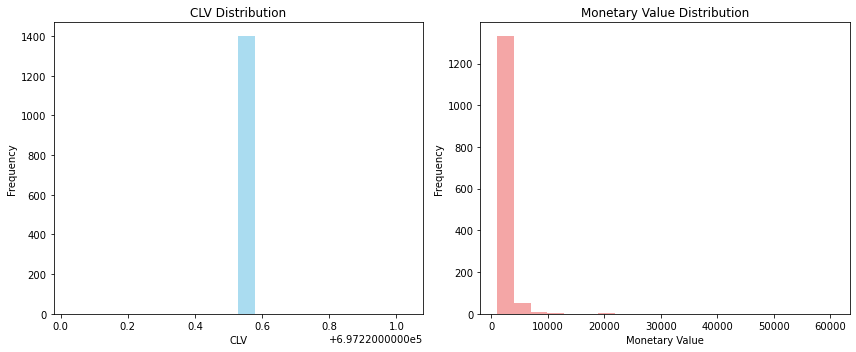

In [36]:
import matplotlib.pyplot as plt

# Extract CLV and Monetary Value from the high-value customers
clv_values = high_value_customers['CLV']
monetary_values = high_value_customers['monetary_value']

# Create a figure with two subplots for CLV and Monetary Value histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot CLV histogram
ax1.hist(clv_values, bins=20, color='skyblue', alpha=0.7)
ax1.set_xlabel('CLV')
ax1.set_ylabel('Frequency')
ax1.set_title('CLV Distribution')

# Plot Monetary Value histogram
ax2.hist(monetary_values, bins=20, color='lightcoral', alpha=0.7)
ax2.set_xlabel('Monetary Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Monetary Value Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


The visualizations of Customer Lifetime Value (CLV) and Monetary Value distributions for high-value customers can provide several insights:

CLV Range: The CLV distribution plot helps you understand the range of CLV values among high-value customers. You can see the spread of CLV values, from lower to higher values, which indicates the variation in the long-term value that these customers bring to the business.

Concentration of Values: Examining the CLV distribution, you can identify whether there's a concentration of high CLV customers or if the distribution is more evenly spread. A high concentration of values on the right side of the plot suggests that a significant portion of high-value customers contributes substantially to CLV.

Monetary Value Range: The Monetary Value distribution plot provides insights into the range of spending by high-value customers. It shows how much these customers are spending, which can be valuable for pricing and product strategy.

Correlation: Comparing the two plots, you can analyze whether there is a correlation between CLV and Monetary Value. For example, do customers who spend more (higher Monetary Value) tend to have higher CLV? This can inform strategies to target customers who have the potential to increase their CLV through increased spending.

### Customer Segmentation

In [37]:
# Merge customers and orders based on customer_id
olist_customer_order = pd.merge(olist_customer, olist_orders, on='customer_id', how='inner')

# Merge customer_order_df with order_items_df based on order_id
olist_customer_order_product = pd.merge(olist_customer_order, olist_order_items, on='order_id', how='inner')

# Merge customer_order_product_df with products_df based on product_id
unified_dataset = pd.merge(olist_customer_order_product, olist_products, on='product_id', how='inner')

In [38]:
unified_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112650 non-null  object        
 1   customer_unique_id             112650 non-null  object        
 2   customer_zip_code_prefix       112650 non-null  int64         
 3   customer_city                  112650 non-null  object        
 4   customer_state                 112650 non-null  object        
 5   order_id                       112650 non-null  object        
 6   order_status                   112650 non-null  object        
 7   order_purchase_timestamp       112650 non-null  datetime64[ns]
 8   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 9   order_purchase_year            112650 non-null  int64         
 10  order_purchase_month           112650 non-null  int64         
 11  

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

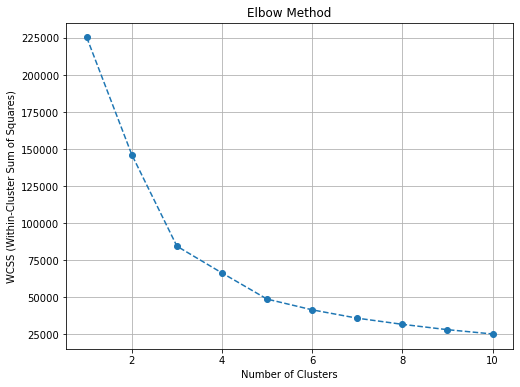

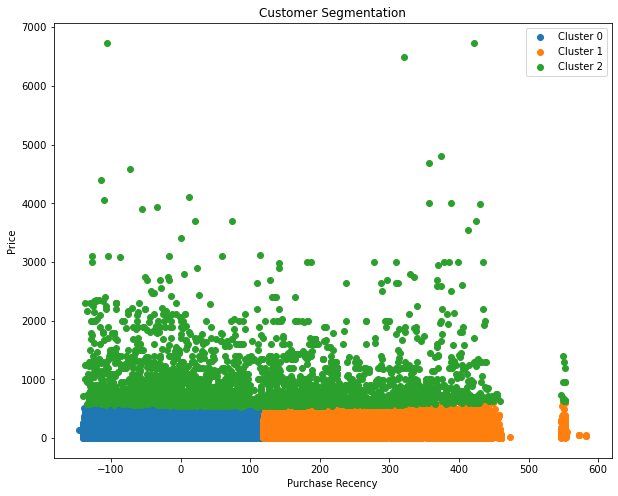

Silhouette Score: 0.4870238337738568


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Assuming you have the 'merged_df' DataFrame from previous calculations

# Select features for segmentation
features = ['purchase_recency', 'price']

# Standardize the features
scaler = StandardScaler()
merged_df_scaled = scaler.fit_transform(merged_df[features])

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(merged_df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.grid()
plt.show()

# Based on the elbow method, choose the optimal number of clusters (e.g., 3)
num_clusters = 3

# Apply K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
merged_df['cluster'] = kmeans.fit_predict(merged_df_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 8))

for cluster in range(num_clusters):
    plt.scatter(
        merged_df[merged_df['cluster'] == cluster]['purchase_recency'],
        merged_df[merged_df['cluster'] == cluster]['price'],
        label=f'Cluster {cluster}',
    )

plt.xlabel('Purchase Recency')
plt.ylabel('Price')
plt.title('Customer Segmentation')
plt.legend()
plt.show()

# Calculate silhouette score to evaluate cluster quality
silhouette_avg = silhouette_score(merged_df_scaled, merged_df['cluster'])
print(f'Silhouette Score: {silhouette_avg}')


**Cluster Characteristics**: By examining the scatter plot, you can analyze the characteristics of each cluster. For instance, Cluster 0 appears to include customers with relatively recent purchases (lower 'purchase_recency') and lower prices. Cluster 1 comprises customers with higher 'purchase_recency' and lower prices, while Cluster 2 has customers with higher 'purchase_recency' and higher prices.

**Segmentation Insights**: The cluster analysis has segmented customers into groups with similar purchase behavior. These segments can be further investigated to understand the factors that differentiate them. For instance, you may explore whether Cluster 0 represents new or infrequent customers, while Cluster 2 could be loyal or high-value customers.

**Targeted Actions**: Understanding the clusters allows you to take targeted actions. For example, you can design retention strategies for customers in Cluster 0, cross-selling for Cluster 1, and loyalty programs for Cluster 2.

In [41]:
from datetime import timedelta, datetime
import squarify
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import re
from pandas.plotting import scatter_matrix
import time, warnings
import datetime as dt
import plotly.offline as py
import plotly.graph_objs as go
import os

In [42]:
pip install squarify


In [43]:
df1 = olist_order_items.merge(olist_order_payments, on='order_id')
print(df1.shape)
df2 = df1.merge(olist_products, on='product_id')
print(df2.shape)
df3 = df2.merge(olist_sellers, on='seller_id')
print(df3.shape)
df4 = df3.merge(olist_order_reviews, on='order_id')
print(df4.shape)
df5 = df4.merge(olist_orders, on='order_id')
print(df5.shape)
#df6 = df5.merge(olist_product_translation, on='product_category_name')
#print(df6.shape)
Olist_db = df5.merge(olist_customer, on='customer_id')
print(Olist_db.shape)

(117601, 11)
(117601, 12)
(117601, 15)
(117329, 19)
(117329, 35)
(117329, 39)


In [44]:
Olist_db.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'product_category_name', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_estimated_delivery_date',
       'order_purchase_year', 'order_purchase_month',
       'order_purchase_month_name', 'order_purchase_year_month',
       'order_purchase_date', 'order_purchase_day', 'order_purchase_dayofweek',
       'order_purchase_dayofweek_name', 'order_purchase_hour',
       'order_purchase_time_day', 'purchase_recency', 'frequency',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')

In [45]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_estimated_delivery_date']
for col in date_columns:
    Olist_db[col] = pd.to_datetime(Olist_db[col], format='%Y-%m-%d %H:%M:%S')

In [46]:
# cleaning up name columns, and engineering new/essential columns
Olist_db['customer_city'] = Olist_db['customer_city'].str.title()
Olist_db['seller_city'] = Olist_db['seller_city'].str.title()
Olist_db['product_category_name'] = Olist_db['product_category_name'].str.title()
Olist_db['payment_type'] = Olist_db['payment_type'].str.replace('_', ' ').str.title()
Olist_db['product_category_name'] = Olist_db['product_category_name'].str.replace('_', ' ')
Olist_db['review_response_time'] = (Olist_db['review_answer_timestamp'] - Olist_db['review_creation_date']).dt.days
#Olist_db['delivery_against_estimated'] = (Olist_db['order_estimated_delivery_date'] - Olist_db['order_delivered_customer_date']).dt.days
#Olist_db['product_size_cm'] = Olist_db['product_length_cm'] * Olist_db['product_height_cm'] * Olist_db['product_width_cm']
Olist_db['order_purchase_year'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.year)
Olist_db['order_purchase_month'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.month)
Olist_db['order_purchase_dayofweek'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.dayofweek)
Olist_db['order_purchase_hour'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.hour)
Olist_db['order_purchase_day'] = Olist_db['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
Olist_db['order_purchase_mon'] = Olist_db.order_purchase_timestamp.apply(lambda x: x.month).map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})


In [47]:
Olist_db.to_csv('Olist_Master.csv', index=False)
Olist_db

order_id  order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214              1   
1       130898c0987d1801452a8ed92a670612              1   
2       532ed5e14e24ae1f0d735b91524b98b9              1   
3       6f8c31653edb8c83e1a739408b5ff750              1   
4       7d19f4ef4d04461989632411b7e588b9              1   
...                                  ...            ...   
117324  fd607d0a02cb276bc764a15f80f0423f              2   
117325  fdaf98feac227eb978d8f33f36e0231d              1   
117326  fe68b52db13993f58175fa589125d345              1   
117327  ff701a7c869ad21de22a6994237c8a00              1   
117328  ff701a7c869ad21de22a6994237c8a00              2   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
...                                  ...                               ...   
117324  02ad78835ec3f72e750d1dfa6a7e11b3  2a73cba571d90c694b7caca072ccf6ce   
117325  f739e9151702508b18f796c53005e5e9  d1aa1ec0839dcab73a6161130eb1f94a   
117326  f4135cbdece8245560f7be179533797a  3fefda3299e6dfaea3466ef346a3571a   
117327  5ff4076c0f01eeba4f728c9e3fa2653c  3e35a8bb43569389d3cebef0ce820f69   
117328  5ff4076c0f01eeba4f728c9e3fa2653c  3e35a8bb43569389d3cebef0ce820f69   

       shipping_limit_date   price  freight_value  payment_sequential  \
0      2017-09-19 09:45:35   58.90          13.29                   1   
1      2017-07-05 02:44:11   55.90          17.96                   1   
2      2018-05-23 10:56:25   64.90          18.33                   1   
3      2017-08-07 18:55:08   58.90          16.17                   1   
4      2017-08-16 22:05:11   58.90          13.29                   1   
...                    ...     ...            ...                 ...   
117324 2018-08-02 02:24:15  171.39          19.35                   1   
117325 2017-04-27 05:10:28  119.90          16.14                   1   
117326 2017-08-17 02:55:27  209.00          16.21                   1   
117327 2018-04-18 20:10:33   27.90          14.44                   1   
117328 2018-04-18 20:10:33   27.90          14.44                   1   

       payment_type  payment_installments  payment_value  \
0       Credit Card                     2          72.19   
1            Boleto                     1          73.86   
2       Credit Card                     2          83.23   
3       Credit Card                     3          75.07   
4       Credit Card                     4          72.19   
...             ...                   ...            ...   
117324       Boleto                     1         381.48   
117325       Boleto                     1         136.04   
117326       Boleto                     1         225.21   
117327  Credit Card                     1          84.68   
117328  Credit Card                     1          84.68   

       product_category_name  seller_zip_code_prefix         seller_city  \
0                 Cool Stuff                   27277       Volta Redonda   
1                 Cool Stuff                   27277       Volta Redonda   
2                 Cool Stuff                   27277       Volta Redonda   
3                 Cool Stuff                   27277       Volta Redonda   
4                 Cool Stuff                   27277       Volta Redonda   
...                      ...                     ...                 ...   
117324      Moveis Decoracao                    9560  Sao Caetano Do Sul   
117325      Moveis Decoracao                   80220            Curitiba   
117326           Eletronicos                   82620            Curitiba   
117327               Bebidas

In [48]:
f = Olist_db.copy()
Olist_db['order_purchase_date'] = Olist_db.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

In [49]:
Olist_db = Olist_db.drop_duplicates()

In [50]:
cond = Olist_db["order_status"] == "delivered"
Olist_db = Olist_db.loc[cond]

In [51]:
Olist_db.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  130898c0987d1801452a8ed92a670612              1   
2  532ed5e14e24ae1f0d735b91524b98b9              1   
3  6f8c31653edb8c83e1a739408b5ff750              1   
4  7d19f4ef4d04461989632411b7e588b9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   

  shipping_limit_date  price  freight_value  payment_sequential payment_type  \
0 2017-09-19 09:45:35   58.9          13.29                   1  Credit Card   
1 2017-07-05 02:44:11   55.9          17.96                   1       Boleto   
2 2018-05-23 10:56:25   64.9          18.33                   1  Credit Card   
3 2017-08-07 18:55:08   58.9          16.17                   1  Credit Card   
4 2017-08-16 22:05:11   58.9          13.29                   1  Credit Card   

   payment_installments  payment_value product_category_name  \
0                     2          72.19            Cool Stuff   
1                     1          73.86            Cool Stuff   
2                     2          83.23            Cool Stuff   
3                     3          75.07            Cool Stuff   
4                     4          72.19            Cool Stuff   

   seller_zip_code_prefix    seller_city seller_state  \
0                   27277  Volta Redonda           SP   
1                   27277  Volta Redonda           SP   
2                   27277  Volta Redonda           SP   
3                   27277  Volta Redonda           SP   
4                   27277  Volta Redonda           SP   

                          review_id  review_score review_creation_date  \
0  97ca439bc427b48bc1cd7177abe71365             5           2017-09-21   
1  b11cba360bbe71410c291b764753d37f             5           2017-07-14   
2  af01c4017c5ab46df6cc810e069e654a             4           2018-06-05   
3  8304ff37d8b16b57086fa283fe0c44f8             5           2017-08-10   
4  426f43a82185969503fb3c86241a9535             5           2017-08-25   

  review_answer_timestamp                       customer_id order_status  \
0     2017-09-22 10:57:03  3ce436f183e68e07877b285a838db11a    delivered   
1     2017-07-17 12:50:07  e6eecc5a77de221464d1c4eaff0a9b64    delivered   
2     2018-06-06 21:41:12  4ef55bf80f711b372afebcb7c715344a    delivered   
3     2017-08-13 03:35:17  30407a72ad8b3f4df4d15369126b20c9    delivered   
4     2017-08-28 00:51:18  91a792fef70ecd8cc69d3c7feb3d12da    delivered   

  order_purchase_timestamp order_estimated_delivery_date  order_purchase_year  \
0      2017-09-13 08:59:02                    2017-09-29                 2017   
1      2017-06-28 11:52:20                    2017-07-26                 2017   
2      2018-05-18 10:25:53                    2018-06-07                 2018   
3      2017-08-01 18:38:42                    2017-08-25                 2017   
4      2017-08-10 21:48:40                    2017-09-01                 2017   

   order_purchase_month order_purchase_month_name order_purchase_year_month  \
0                     9                       Sep                    201709   
1                     6                       Jun                    201706   
2                     5                       May                    201805   
3                     8                       Aug                    201708   
4                     8                       Aug                    201708   

  order_purchase_date order_purchase_day  order_purchase_dayofweek  \
0 2017-09-13 08:59:02                Wed                         2   
1 2017-06-28 11:52:20                Wed          

In [52]:
Olist_db['InvoiceDate'] = Olist_db['order_purchase_date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
print('{:,} rows; {:,} columns'
      .format(Olist_db.shape[0], Olist_db.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(Olist_db[Olist_db.customer_unique_id.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(Olist_db['InvoiceDate'].min(),
                                    Olist_db['InvoiceDate'].max()))
print('Payment value range from {} to {}'.format(Olist_db['payment_value'].min(), Olist_db['payment_value'].max()))

114,859 rows; 42 columns
0 transactions don't have a customer id
Transactions timeframe from 2016-10-03 to 2018-08-29
Payment value range from 0.0 to 13664.08


In [53]:
Olist_db['InvoiceDate'] = pd.to_datetime(Olist_db['InvoiceDate'])
# Create snapshot date
snapshot_date = Olist_db['InvoiceDate'].max() + timedelta(days=1)
snapshot_date


Timestamp('2018-08-30 00:00:00')

In [54]:
#GROUPING BY CUSTOMER ID
data_process = Olist_db.groupby(['customer_unique_id']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'payment_value': 'sum'})
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'order_id': 'Frequency',
                         'payment_value': 'Monetary'}, inplace=True)
data_process

Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19
0000f46a3911fa3c0805444483337064      538          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      322          1     43.62
0004aac84e0df4da2b147fca70cf8255      289          1    196.89
...                                   ...        ...       ...
fffcf5a5ff07b0908bd4e2dbc735a684      448          2   4134.84
fffea47cd6d3cc0a88bd621562a9d061      263          1     84.58
ffff371b4d645b6ecea244b27531430a      569          1    112.46
ffff5962728ec6157033ef9805bacc48      120          1    133.69
ffffd2657e2aad2907e67c3e9daecbeb      485          1     71.56

[92754 rows x 3 columns]

In [55]:
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).values.argmax()
    return series.rank(pct=1).apply(f)

In [56]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 2)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pct_rank_qcut(data_process['Frequency'], 4)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)

# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['Monetary'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [67]:
#CONCAT RFM QUARTILE VALUES TO CREATE RFM SEGMENT
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data_process['RFM_segment'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

Recency  Frequency  Monetary  R  F  M  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90  4  2  3   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19  4  2  1   
0000f46a3911fa3c0805444483337064      538          1     86.22  1  2  2   
0000f6ccb0745a6a4b88665a16c9f078      322          1     43.62  2  2  1   
0004aac84e0df4da2b147fca70cf8255      289          1    196.89  2  2  3   

                                 RFM_segment  RFM_Score  
customer_unique_id                                       
0000366f3b9a7992bf8c76cfdf3221e2         423          9  
0000b849f77a49e4a4ce2b2a4ca5be3f         421          7  
0000f46a3911fa3c0805444483337064         122          5  
0000f6ccb0745a6a4b88665a16c9f078         221          5  
0004aac84e0df4da2b147fca70cf8255         223          7

In [68]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_segment')['RFM_segment'].nunique()
print(rfm_count_unique.sum())

32


In [69]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    9
0000b849f77a49e4a4ce2b2a4ca5be3f    7
0000f46a3911fa3c0805444483337064    5
0000f6ccb0745a6a4b88665a16c9f078    5
0004aac84e0df4da2b147fca70cf8255    7
Name: RFM_Score, dtype: int64


### Segmentation using RFM Analysis | Identify Upselling and Cross selling opportunities

In [70]:
# Define rfm_level function
def rfm_level(df):
    if (df['RFM_segment'] >= 434 | (df['RFM_Score'] >= 9)) :
        return 'VVIP - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) & (df['M'] == 4)):
        return 'Champions Big Spenders'
    elif ((df['RFM_Score'] >= 6) & (df['F'] >= 2)):
        return 'Loyal Customers'
    elif ((df['RFM_Score'] <= 4) & (df['R'] == 1)):
        return 'Hibernating Almost Lost'
    elif ((df['RFM_segment'] >= 221) | (df['RFM_Score'] >= 6)):
        return 'Potential Loyalists'
    elif ((df['RFM_segment'] >= 121) & (df['R'] == 1) | (df['RFM_Score'] == 5)):
        return 'Needs Attention'
    else:
        return 'Lost Customers'

In [71]:
# Define rfm marketing action function
def rfm_action(df):
    if (df['RFM_segment'] >= 434 | (df['RFM_Score'] >= 9)) :
        return 'No Price Incentives; Offer Limited edition and Loyality programs'
    elif ((df['RFM_Score'] >= 8) & (df['M'] == 4)):
        return 'Upsell most expensive items'
    elif ((df['RFM_Score'] >= 6) & (df['F'] >= 2)):
        return 'Loyality programs;Cross Sell'
    elif ((df['RFM_Score'] <= 4) & (df['R'] == 1)):
        return 'Aggressive price incentives'
    elif ((df['RFM_segment'] >= 221) | (df['RFM_Score'] >= 6)):
        return 'Cross Sell Recommendations and Discount coupons'
    elif (((df['RFM_segment'] >= 121) & (df['R'] == 1)) | (df['RFM_Score'] == 5)):
        return 'Price incentives and Limited time offer'
    else:
        return 'Don\'t spend too much trying to re-acquire'

In [72]:
# Create a new variable RFM_Level
rfm['RFM_segment'] = rfm.RFM_segment.apply(lambda x: int(x))
rfm['Customer Segment'] = rfm.apply(rfm_level, axis=1)
# Create a new variable RFM_Level
rfm['Marketing Action'] = rfm.apply(rfm_action, axis=1)
rfm.head(10)

Recency  Frequency  Monetary  R  F  M  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90  4  2  3   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19  4  2  1   
0000f46a3911fa3c0805444483337064      538          1     86.22  1  2  2   
0000f6ccb0745a6a4b88665a16c9f078      322          1     43.62  2  2  1   
0004aac84e0df4da2b147fca70cf8255      289          1    196.89  2  2  3   
0004bd2a26a76fe21f786e4fbd80607f      147          1    166.98  3  2  3   
00050ab1314c0e55a6ca13cf7181fecf      132          1     35.38  3  2  1   
00053a61a98854899e70ed204dd4bafe      183          2    838.36  3  4  4   
0005e1862207bf6ccc02e4228effd9a0      544          1    150.12  1  2  3   
0005ef4cd20d2893f0d9fbd94d3c0d97      171          1    129.76  3  2  3   

                                  RFM_segment  RFM_Score  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          423          9   
0000b849f77a49e4a4ce2b2a4ca5be3f          421          7   
0000f46a3911fa3c0805444483337064          122          5   
0000f6ccb0745a6a4b88665a16c9f078          221          5   
0004aac84e0df4da2b147fca70cf8255          223          7   
0004bd2a26a76fe21f786e4fbd80607f          323          8   
00050ab1314c0e55a6ca13cf7181fecf          321          6   
00053a61a98854899e70ed204dd4bafe          344         11   
0005e1862207bf6ccc02e4228effd9a0          123          6   
0005ef4cd20d2893f0d9fbd94d3c0d97          323          8   

                                        Customer Segment  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2         Loyal Customers   
0000b849f77a49e4a4ce2b2a4ca5be3f         Loyal Customers   
0000f46a3911fa3c0805444483337064         Needs Attention   
0000f6ccb0745a6a4b88665a16c9f078     Potential Loyalists   
0004aac84e0df4da2b147fca70cf8255         Loyal Customers   
0004bd2a26a76fe21f786e4fbd80607f         Loyal Customers   
00050ab1314c0e55a6ca13cf7181fecf         Loyal Customers   
00053a61a98854899e70ed204dd4bafe  Champions Big Spenders   
0005e1862207bf6ccc02e4228effd9a0         Loyal Customers   
0005ef4cd20d2893f0d9fbd94d3c0d97         Loyal Customers   

                                                                 Marketing Action  
customer_unique_id                                                                 
0000366f3b9a7992bf8c76cfdf3221e2                     Loyality programs;Cross Sell  
0000b849f77a49e4a4ce2b2a4ca5be3f                     Loyality programs;Cross Sell  
0000f46a3911fa3c0805444483337064          Price incentives and Limited time offer  
0000f6ccb0745a6a4b88665a16c9f078  Cross Sell Recommendations and Discount coupons  
0004aac84e0df4da2b147fca70cf8255                     Loyality programs;Cross Sell  
0004bd2a26a76fe21f786e4fbd80607f                     Loyality programs;Cross Sell  
00050ab1314c0e55a6ca13cf7181fecf                     Loyality programs;Cross Sell  
00053a61a98854899e70ed204dd4bafe                      Upsell most expensive items  
0005e1862207bf6ccc02e4228effd9a0                     Loyality programs;Cross Sell  
0005ef4cd20d2893f0d9fbd94d3c0d97                     Loyality programs;Cross Sell

In [73]:
rfm['Customer Segment'].value_counts()

Loyal Customers            55225
Champions Big Spenders     17288
Hibernating Almost Lost     5659
Needs Attention             5588
Potential Loyalists         5521
VVIP - Can't Loose Them     3473
Name: Customer Segment, dtype: int64

##### Grouping Customers by Customer Segment

In [74]:
#Calculate Average values for each customer segment and return size of each segment
rfm_level_agg = rfm.groupby(['Customer Segment']).agg({
        'Recency': 'mean',
        'Frequency' : 'mean',
        'Monetary': ['mean', 'count'],
        'Marketing Action' : 'unique'
}).round(1)
#print the aggregated dataset
print(rfm_level_agg)

                        Recency Frequency Monetary         \
                           mean      mean     mean  count   
Customer Segment                                            
Champions Big Spenders    217.8       1.7    562.4  17288   
Hibernating Almost Lost   454.9       1.0     43.8   5659   
Loyal Customers           208.8       1.1    126.0  55225   
Needs Attention           447.1       1.0     85.3   5588   
Potential Loyalists       276.4       1.0     44.1   5521   
VVIP - Can't Loose Them    60.7       2.6    582.1   3473   

                                                          Marketing Action  
                                                                    unique  
Customer Segment                                                            
Champions Big Spenders                       [Upsell most expensive items]  
Hibernating Almost Lost                      [Aggressive price incentives]  
Loyal Customers                             [Loyality programs;Cr

In [75]:
rfm_level_ag = pd.DataFrame(rfm_level_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

Customer Segment Recency Frequency Monetary         \
                              mean      mean     mean  count   
0   Champions Big Spenders   217.8       1.7    562.4  17288   
1  Hibernating Almost Lost   454.9       1.0     43.8   5659   
2          Loyal Customers   208.8       1.1    126.0  55225   
3          Needs Attention   447.1       1.0     85.3   5588   
4      Potential Loyalists   276.4       1.0     44.1   5521   
5  VVIP - Can't Loose Them    60.7       2.6    582.1   3473   

                                    Marketing Action  
                                              unique  
0                      [Upsell most expensive items]  
1                      [Aggressive price incentives]  
2                     [Loyality programs;Cross Sell]  
3          [Price incentives and Limited time offer]  
4  [Cross Sell Recommendations and Discount coupons]  
5  [No Price Incentives; Offer Limited edition an...

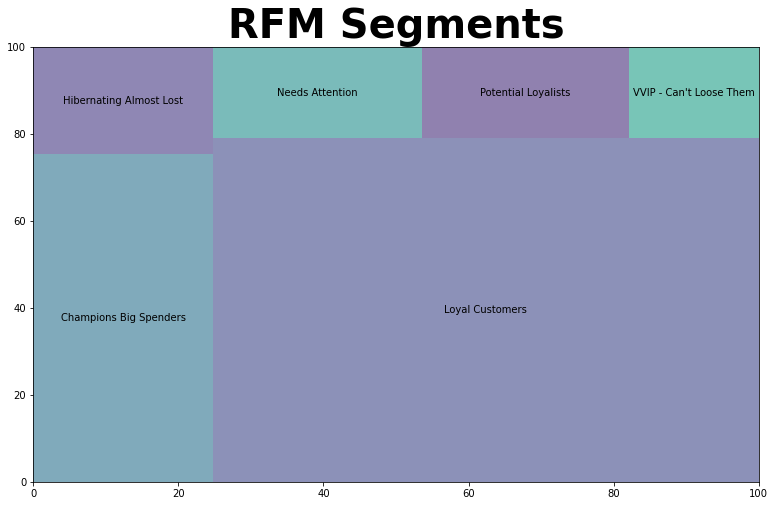

In [76]:
#rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count', 'MarketingAction']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 8)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Champions Big Spenders',
                     'Hibernating Almost Lost',
                     'Loyal Customers',
                     'Needs Attention',
                     'Potential Loyalists',
                     'VVIP - Can\'t Loose Them'], alpha=.6 )
plt.title("RFM Segments",fontsize=40,fontweight="bold")
plt.axis('on')
plt.show()

In [77]:
import plotly.graph_objects as go

fig =go.Figure(go.Treemap(
    labels = rfm_level_ag['Customer Segment'],
    parents = ['Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation', 'Customer Segmentation'],   #rfm_level_ag[('Marketing Action', 'unique')].tolist(), 
    values= rfm_level_ag[('Monetary', 'count')]
))

fig.show()